https://quantscience.rbind.io/2020/03/07/using-julia-find-mle-factor-model/

## Set Seed

In [1]:
using Random, Distributions
Random.seed!(123) # Setting the seed

MersenneTwister(123)

## Generate Univarate Normal Data
Let’s generate some normal data. In Julia the Distribution.Normal function can be used to set a Normal distribution. The Base.rand function will then generate data from that class. I was amazed that the Distributions package supported a wide range of distributions.

In [2]:
d = Normal()
x = rand(d, 100)

100-element Vector{Float64}:
  1.1902678809862768
  2.04817970778924
  1.142650902867199
  0.45941562040708034
 -0.396679079295223
 -0.6647125451916877
  0.9809678267585334
 -0.07548306639775595
  0.27381537121215616
 -0.19422906710572047
 -0.33936602980781916
 -0.84387792144707
 -0.8889357468973064
  ⋮
 -0.7339610029444202
  0.45939803668120377
  1.7061863874321828
  0.6784427697934589
  0.28717953880710856
  1.0681555054109295
 -0.3068768981211787
 -1.9202140874350073
  1.6696020873668111
 -0.2135576214062456
 -0.16371133936712523
 -0.9029858060964956

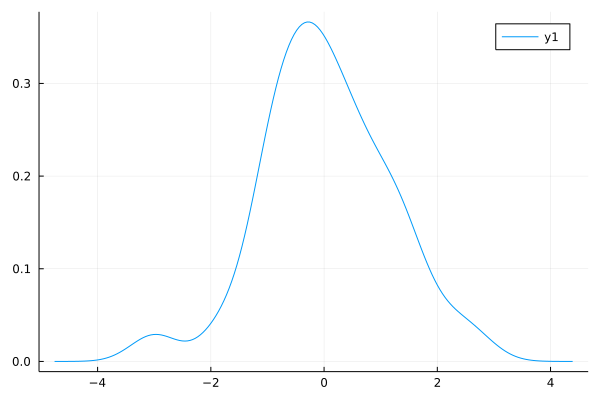

In [3]:
using StatsPlots
density(x)

## Generate Multivariate Normal Data

In [4]:
d = MvNormal([1 0.5
              0.5 1])

ZeroMeanFullNormal(
dim: 2
μ: Zeros(2)
Σ: [1.0 0.5; 0.5 1.0]
)


In [5]:
x = rand(d, 1000)

2×1000 Matrix{Float64}:
  0.376264  1.33585  -1.45789    0.895878  …  0.80866   -0.808233   0.52911
 -0.162844  2.05423  -0.035615  -0.151293     0.412493   0.387994  -0.126699

In [6]:
# Covariance matrix
using LinearAlgebra
cov(x')

2×2 Matrix{Float64}:
 1.00907   0.523942
 0.523942  0.983592

The above shows how Julia can simulate multivariate normal data. Now, generate some cfa data

In [7]:
Λ = [.7
     .7
     .7
     .7]
Σ = Λ*Λ' + Diagonal(ones(4) * .51)

4×4 Matrix{Float64}:
 1.0   0.49  0.49  0.49
 0.49  1.0   0.49  0.49
 0.49  0.49  1.0   0.49
 0.49  0.49  0.49  1.0

In [8]:
# Simulate data
y = rand(MvNormal(Σ), 100)
Sy = cov(y')

4×4 Matrix{Float64}:
 1.05629   0.483003  0.568291  0.527303
 0.483003  0.996153  0.29745   0.478035
 0.568291  0.29745   0.97717   0.398606
 0.527303  0.478035  0.398606  1.06493

In [9]:
function loglik(θ, S = Sy)
    Λ = θ[1:4]
    Θ = Diagonal(θ[5:8])
    Σ = Λ*Λ' + Θ
    logdet(Σ) + tr(Σ\Sy)
end

loglik (generic function with 2 methods)

In [10]:
# Try the function
loglik([.8, .7, .7, .7, .51, .51, .51, .51])

3.167285493401312

In [11]:
# Find maximum likelihood estimates
using Optim
@time optimize(loglik, [ones(4) * 0.7; ones(4) * 0.51], LBFGS())

  1.640046 seconds (1.87 M allocations: 112.521 MiB, 5.42% gc time, 99.60% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     3.106121e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.98e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.70e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.41e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.53e-14 ≰ 0.0e+00
    |g(x)|                 = 6.23e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    12
    f(x) calls:    33
    ∇f(x) calls:   33


In [12]:
# Use Hessians
using NLSolversBase, ForwardDiff
td = TwiceDifferentiable(loglik, [ones(4) * 0.7; ones(4) * 0.51]; autodiff = :forward)
@time opt = optimize(td, [ones(4) * 0.7; ones(4) * 0.51])

 18.238344 seconds (30.54 M allocations: 1.466 GiB, 3.70% gc time, 5.03% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     3.106121e+00

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 2.04e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.42e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.12e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.62e-12 ≰ 0.0e+00
    |g(x)|                 = 8.54e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    4
    f(x) calls:    13
    ∇f(x) calls:   13
    ∇²f(x) calls:  4


In [13]:
# Numerical Hessian
Optim.minimizer(opt)
@time ForwardDiff.hessian(loglik, Optim.minimizer(opt))

  0.870712 seconds (2.04 M allocations: 128.827 MiB, 5.44% gc time, 99.96% compilation time)


8×8 Matrix{Float64}:
  3.20996   -0.510624   -0.721864  …  -0.169641   -0.169149   -0.264187
 -0.510624   2.24204    -0.158485      0.483349   -0.169213    0.0201712
 -0.721864  -0.158485    2.48657      -0.135797    0.660268   -0.113498
 -0.564463  -0.312079   -0.254539      0.0172733  -0.121108    0.563431
  1.68921   -0.475787   -0.380722      0.227343    0.119383    0.391444
 -0.169641   0.483349   -0.135797  …   1.85791     0.111418   -0.0513068
 -0.169149  -0.169213    0.660268      0.111418    2.23284     0.0729978
 -0.264187   0.0201712  -0.113498     -0.0513068   0.0729978   1.85126

In [17]:
# Using NLSolverBase
@time hess = NLSolversBase.hessian!(td, Optim.minimizer(opt))

  0.000012 seconds


8×8 Matrix{Float64}:
  3.20996   -0.510624   -0.721864  …  -0.169641   -0.169149   -0.264187
 -0.510624   2.24204    -0.158485      0.483349   -0.169213    0.0201712
 -0.721864  -0.158485    2.48657      -0.135797    0.660268   -0.113498
 -0.564463  -0.312079   -0.254539      0.0172733  -0.121108    0.563431
  1.68921   -0.475787   -0.380722      0.227343    0.119383    0.391444
 -0.169641   0.483349   -0.135797  …   1.85791     0.111418   -0.0513068
 -0.169149  -0.169213    0.660268      0.111418    2.23284     0.0729978
 -0.264187   0.0201712  -0.113498     -0.0513068   0.0729978   1.85126

In [18]:
# Asymptotic covariance matrix
diag(inv(hess) * 2 / 100)

8-element Vector{Float64}:
 0.010589204573074763
 0.010906273403888831
 0.009821304562058196
 0.011702374569422469
 0.012630958879887428
 0.012224164343998667
 0.009930610842226427
 0.013573138910062699